# Wrangle OpenStreetMap Data

Renee Cothern
June, 2020


## Table of Contents
<ul>
<li><a href="#intro">Map Area</a></li>
<li><a href="#problems">Problems Encountered in Map</a></li>
    <ul>
        <li><a href="#tags">Tags of different types and tag problems</a></li>
        <li><a href="#zips">Testing for zip codes that don't conform</a></li>
        <li><a href="#cities">Testing for wrong entries in "city"</a></li>
        <li><a href="#streets">Testing for inconsistent entries in Street Name (types and directional information)</a></li> 
    </ul>
<li><a href="#overview">Overview of the Data</a></li>
    <ul>
        <li><a href="#prep">Preparing for Database</a></li>
        <li><a href="#files">File Sizes</a></li>
        <li><a href="#evaluating">Evaluating the Dataset (Queries)</a></li>
    </ul>
<li><a href="#ideas">Ideas about the Dataset</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Map Area

### Area investigated:  Bend, OR
https://www.openstreetmap.org/relation/186761#map=12/44.0613/-121.3153

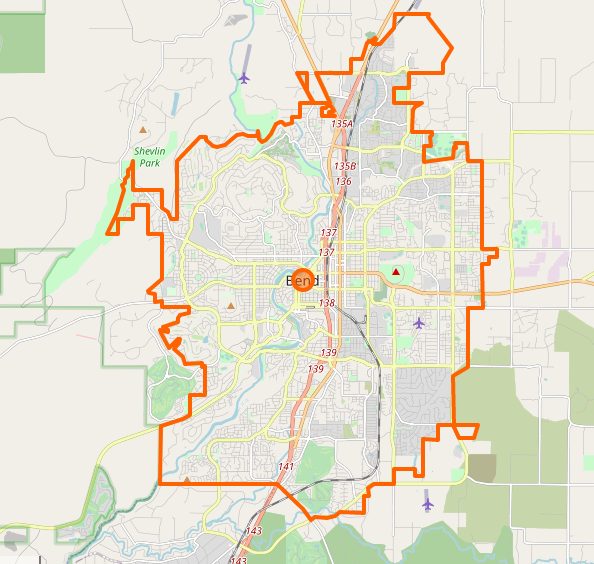

This is one of the areas I grew up in, and was interested in how it has grown.

Latitude and Longitude:
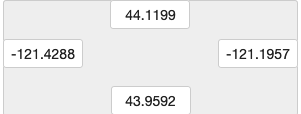
<br>

bounds minlat="43.9592000" minlon="-121.4288000" maxlat="44.1199000" maxlon="-121.1957000"

#### Looking at the size of the xml file, it's around: <p style="color:red;">58.7 mb</p>
<br>
-rw-r--r--@ 1 reneecothern  staff  58742750 Jun 17 10:50 mapBend.xml


<a id='problems'></a>
## Problems Encountered in Map

<a id='tags'></a>
### Tags of different types
I will look at to get at the individual tag in my XML file to get an understanding on how much of which data I can expect.



In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import xml.etree.cElementTree as ET
import pprint

#create a count of the tags
def count_tags(filename):
        countdict = {}
        tree = ET.ElementTree(file=filename)
        for elem in tree.iter():
            if elem.tag in countdict:
                countdict[elem.tag] += 1
            else:
                countdict[elem.tag] = 1
        return countdict
            
            

tags = count_tags('mapBend2.osm')
pprint.pprint(tags)



{'bounds': 1,
 'member': 1591,
 'meta': 1,
 'nd': 309577,
 'node': 268214,
 'note': 1,
 'osm': 1,
 'relation': 144,
 'tag': 97825,
 'way': 31847}


<br>
<b>My dataset is quite large, so I will create the <em>sample.osm</em> so I have something to test with.</b>

In [2]:
#global variables
OSM_FILE = "mapBend2.osm"  
SAMPLE_FILE = "sample.osm"

k = 10 # Parameter: take every k-th top level element

def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag

    Reference:
    http://stackoverflow.com/questions/3095434/inserting-newlines-in-xml-file-generated-via-xml-etree-elementtree-in-python
    """
    context = iter(ET.iterparse(osm_file, events=('start', 'end')))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


with open(SAMPLE_FILE, 'wb') as output:
    output.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    output.write('<osm>\n  ')

    # Write every kth top level element
    for i, element in enumerate(get_element(OSM_FILE)):
        if i % k == 0:
            output.write(ET.tostring(element, encoding='utf-8'))

    output.write('</osm>')

  ### Testing for tags that may be problems 
* "lower", for tags that contain only lowercase letters and are valid
* "lower_colon", for otherwise valid tags with a colon in their names
* "problemchars", for tags with problematic characters, and
* "other", for other tags that do not fall into the other three categories.

The result shows that the k attributes for the tag fields have no problem characters.

In [3]:
import re

#compile global regex tests
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

#function to count the problems and return the results
def key_type(element, keys):
    if element.tag == "tag":
        k_attrib = element.attrib['k']
        result_lower = lower.match(k_attrib)
        result_lower_colon = lower_colon.match(k_attrib)
        result_problemchars = problemchars.match(k_attrib)
        
        if result_lower:
            keys['lower'] += 1
        if result_lower_colon:
            keys['lower_colon'] += 1
        if result_problemchars:
            keys['problemchars'] += 1
        if not result_lower and not result_lower_colon and not result_problemchars:
            keys['other'] += 1
        pass
        
    return keys


#create the dictionary and process the issues in key_type function
def process_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)

    return keys

#start here, run the process_map, print the result
keys = process_map(OSM_FILE)
pprint.pprint(keys)


{'lower': 74946, 'lower_colon': 21794, 'other': 1085, 'problemchars': 0}


<a id='zips'></a>
### Testing for zip codes that don't conform
With this set I used the following website to find all the valid zip codes for the area:
https://www.zip-codes.com/city/or-bend.asp
<br>
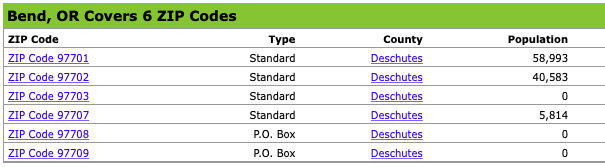

In [4]:
expected = ["97701", "97702","97703", "97707", "97708", "97709"]
zips = set()

#ran from audit if it's a zip code that's not in the expected list,
# it'll populate the zips set to prevent duplicates - I just want a report for now
def audit_zip(zips, zip_code):
    if zip_code not in expected:
        zips.add(zip_code)

#used during audit function
def is_zip_code(elem):
    return (elem.attrib['k'] == "addr:postcode")

#check if the tag is a zip code using function, if it is run audit_zip function
def audit(osmfile):
    osm_file = open(osmfile, "r")
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_zip_code(tag):
                    audit_zip(zips, tag.attrib['v'])
    return zips

#start here, run the audit function, and print the result
zips = audit(OSM_FILE)
print("Zip codes that are wrong:")
if len(zips) == 0:
    print("******Zip Codes are all valid!")
else:
    print(zips)




Zip codes that are wrong:
******Zip Codes are all valid!


<a id='cities'></a>
### Testing for wrong entries in "city"
All information should show the city to be Bend.  I found one incorrect entry.  

In [5]:
expected_city = ["Bend"]
city_test = []

#ran from audit function if it's not Bend, then add it to the city_test list 
#to get an idea of the number of problems
def audit_city(city_test, city):
    if city not in expected_city:
        city_test.append(city)

#ran from audit function to determine if a tag is a city
def is_city(elem):
    return (elem.attrib['k'] == "addr:city")

#open the file, if the tag is a city, run the audit_city function
def audit(osmfile):
    osm_file = open(osmfile, "r")
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_city(tag):
                    audit_city(city_test, tag.attrib['v'])

#start here, run the audit function
audit(OSM_FILE)
print("City entries that are wrong:")
if len(city_test) == 0:
    print("******City entries are all valid!")
else:
    print(city_test)
    print("Number of wrong entries: ", len(city_test))


City entries that are wrong:
['ch']
('Number of wrong entries: ', 1)


<a id='streets'></a>
### Testing for inconsistent entries in Street Name - Part 1
All information should show consistent street types, such as Avenue vs. Ave. Not all the data had consistent street types, though most of it did. 


In [6]:
from collections import defaultdict

#regex test
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)


expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road", 
            "Trail", "Parkway", "Commons", "97", "20", "Loop", "Way", "Alley", "Highway"]

# mapping used to update the street types
mapping = { "St": "Street",
            "St.": "Street",
            "Ave": "Avenue",
            "Ave.": "Avenue",
            "Rd": "Road",
            "Rd.": "Road",
            "Lp.": "Loop",
            "Lp": "Loop",
            "Dr": "Drive",
            "Dr.": "Drive",
            "Wy": "Way",
            "Ln.": "Lane",
            "Ln": "Lane",
            "Blvd.": "Boulevard",
            "Blvd": "Boulevard",
            "Pl": "Place",
            "Pl.": "Place"
            }

#ran from audit if street type is not in expected above, then populate the street dict
def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)

#ran from audit to determine if the tag is a street
def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

#open the file, if it's a tag and is a street name then run audit_street_type function
def audit(osmfile):
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    osm_file.close()
    return street_types

#ran to update the street names to the correct names
def update_name(name, mapping): #individual address, and mapping dictionary above
    found_type = street_type_re.search(name)
    if found_type:
        street_type = found_type.group()
        if street_type in mapping:
            #find the street_type in the mapping file, and put value in new_street_type
            new_street_type = mapping[street_type]
            #find the wrong street type in address, and replace with new
            name = name.replace(street_type, new_street_type)

    return name #return correct address and place in better_name located below

#start here, run the audit function with the OSM_FILE and return the st_types defaultdict
st_types = audit(OSM_FILE)
pprint.pprint(dict(st_types))

for st_type, ways in st_types.iteritems():
    #for each address found
    for name in ways:
        #take the address and the mapping, and run update_name function
        better_name = update_name(name, mapping)
        print name, "=>", better_name



{'110': set(['Northwest Crossing Drive #110']),
 'Ave': set(['SW Simpson Ave']),
 'Blvd': set(['NW Riverside Blvd']),
 'Dr': set(['NE Azure Dr', 'SW Upper Terrace Dr']),
 'Pl': set(['NW Prairie Pl']),
 'St': set(['NE Division St', 'NW Union St', 'NW Wall St'])}
NW Wall St => NW Wall Street
NE Division St => NE Division Street
NW Union St => NW Union Street
Northwest Crossing Drive #110 => Northwest Crossing Drive #110
NW Riverside Blvd => NW Riverside Boulevard
SW Simpson Ave => SW Simpson Avenue
SW Upper Terrace Dr => SW Upper Terrace Drive
NE Azure Dr => NE Azure Drive
NW Prairie Pl => NW Prairie Place


### Testing for inconsistent entries in Street Name - Part 2
All street names should show consistent compass street directional indicators,  such as Northwest, instead of NW.

In [7]:
#open file, and fix directional street names so it's consistent.
# and while we're add it, let's fix that one broken city too...
def audit_street_compass(elem):
    #osm_file = open(osmfile, "r")
    #for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    street_name = tag.attrib['v']
                    matches = ["NW", "SW", "NE", "SE"]
                    if any(x in street_name for x in matches):
                        print ("Old street name: ", street_name)
                        street_name = street_name.replace('NW', 'Northwest')
                        street_name = street_name.replace('SW', 'Southwest')
                        street_name = street_name.replace('NE', 'Northeast')
                        street_name = street_name.replace('SE', 'Southeast')
                        print ("New street name: ", street_name)
                #remember the one entry that was bad in 'Testing for wrong entries in "city"'?  Fixing it!
                if is_city(tag):
                    city_name = tag.attrib['v']
                    if 'ch' in city_name:
                        print ("Old city name: ", city_name)
                        city_name = city_name.replace('ch', 'Bend')
                        print ("New city name: ", city_name)
    


#start here, run audit_street_compass
osm_file = open(OSM_FILE, "r")
for event, elem in ET.iterparse(osm_file, events=("start",)):
    audit_street_compass(elem)
osm_file.close()

('Old street name: ', 'SW Simpson Ave')
('New street name: ', 'Southwest Simpson Ave')
('Old street name: ', 'SE Scott Street')
('New street name: ', 'Southeast Scott Street')
('Old street name: ', 'NE Cushing Drive')
('New street name: ', 'Northeast Cushing Drive')
('Old street name: ', 'NE Cushing Drive')
('New street name: ', 'Northeast Cushing Drive')
('Old street name: ', 'NW Prairie Pl')
('New street name: ', 'Northwest Prairie Pl')
('Old street name: ', 'SW Upper Terrace Dr')
('New street name: ', 'Southwest Upper Terrace Dr')
('Old street name: ', 'NE Division St')
('New street name: ', 'Northeast Division St')
('Old street name: ', 'NE Azure Dr')
('New street name: ', 'Northeast Azure Dr')
('Old street name: ', 'NW Wall St')
('New street name: ', 'Northwest Wall St')
('Old street name: ', 'NW Riverside Blvd')
('New street name: ', 'Northwest Riverside Blvd')
('Old city name: ', 'ch')
('New city name: ', 'Bend')
('Old street name: ', 'NW Union St')
('New street name: ', 'Northw

<a id='overview'></a>
## Overview of the Data

<a id='prep'></a>
### Preparing for Database
The next step is to prepare the data to be inserted into a SQL database.  The below parses the elements in the OSM XML file transforming then to a tabular format, thus making it possible to write to .csv files. These csv files can then easily be
imported to a SQL database as tables.

In [8]:
#schema used to validate data
schema = {
    'node': {
        'type': 'dict',
        'schema': {
            'id': {'required': True, 'type': 'integer', 'coerce': int},
            'lat': {'required': True, 'type': 'float', 'coerce': float},
            'lon': {'required': True, 'type': 'float', 'coerce': float},
            'user': {'required': True, 'type': 'string'},
            'uid': {'required': True, 'type': 'integer', 'coerce': int},
            'version': {'required': True, 'type': 'string'},
            'changeset': {'required': True, 'type': 'integer', 'coerce': int},
            'timestamp': {'required': True, 'type': 'string'}
        }
    },
    'node_tags': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'key': {'required': True, 'type': 'string'},
                'value': {'required': True, 'type': 'string'},
                'type': {'required': True, 'type': 'string'}
            }
        }
    },
    'way': {
        'type': 'dict',
        'schema': {
            'id': {'required': True, 'type': 'integer', 'coerce': int},
            'user': {'required': True, 'type': 'string'},
            'uid': {'required': True, 'type': 'integer', 'coerce': int},
            'version': {'required': True, 'type': 'string'},
            'changeset': {'required': True, 'type': 'integer', 'coerce': int},
            'timestamp': {'required': True, 'type': 'string'}
        }
    },
    'way_nodes': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'node_id': {'required': True, 'type': 'integer', 'coerce': int},
                'position': {'required': True, 'type': 'integer', 'coerce': int}
            }
        }
    },
    'way_tags': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'key': {'required': True, 'type': 'string'},
                'value': {'required': True, 'type': 'string'},
                'type': {'required': True, 'type': 'string'}
            }
        }
    }
}


In [10]:
import csv
import codecs
#used for validation
import cerberus


OSM_PATH = OSM_FILE
#OSM_PATH = SAMPLE_FILE

NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

LOWER_COLON = re.compile(r'^([a-z]|_)+:([a-z]|_)+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

SCHEMA = schema

NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']


def shape_element(element, node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS,
                  problem_chars=PROBLEMCHARS, default_tag_type='regular'):
    """Clean and shape node or way XML element to Python dict"""

    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []  # Handle secondary tags the same way for both node and way elements
    
    #MOD: UPDATE the address street types
    if element.tag == "node" or element.tag == "way":
            for tag in element.iter("tag"):
                if is_street_name(tag):
                    name = tag.attrib['v']
                    update_name(name, mapping)
    
    #MOD: UPDATE the address street directions
    audit_street_compass(element)
    
    
    # Creates all the needed dictionaries and lists to export them to csvs
    if element.tag == 'node':
        for node_key in node_attr_fields:
            the_attrib_value = element.get(node_key)
            node_attribs[node_key] = the_attrib_value
        for child in element:
            #process the node_tags key
            if child.tag == 'tag':
                tags_dict = {}
                k_attrib = child.get('k')
                v_attrib = child.get('v')
                a_problem = problem_chars.search(k_attrib)
                tags_dict['id'] = element.get('id')
                tags_dict['value'] = v_attrib
                #Make sure problem characters aren't there
                if a_problem == None:
                    colon = LOWER_COLON.search(k_attrib)
                    if colon != None:
                        k_attrib_list = k_attrib.split(':', 1)
                        first_part_attrib = k_attrib_list[0]
                        second_part_attrib = k_attrib_list[1]
                        tags_dict['key'] = second_part_attrib
                        tags_dict['type'] = first_part_attrib
                    else:
                        tags_dict['key'] = k_attrib
                        tags_dict['type'] = default_tag_type
                    tags.append(tags_dict)
        return {'node': node_attribs, 'node_tags': tags}
    
    elif element.tag == 'way':
        for way_key in way_attr_fields:
            the_attrib_value = element.get(way_key)
            way_attribs[way_key] = the_attrib_value
        nd_count = 0
        
        for child in element:
            #process way nodes
            if child.tag == 'nd':
                nodes_dict = {}
                nodes_dict['id'] = element.get('id')
                nodes_dict['node_id'] = child.get('ref')
                nodes_dict['position'] = nd_count
                nd_count += 1
                way_nodes.append(nodes_dict)
                
            #process the way_tags key
            if child.tag == 'tag':
                k_attrib = child.get('k')
                v_attrib = child.get('v')
                a_problem = problem_chars.search(k_attrib)
                tags_dict = {}
                tags_dict['id'] = element.get('id')
                
                #Make sure problem characters aren't there
                if a_problem == None:
                    colon = LOWER_COLON.search(k_attrib)
                    tags_dict['value'] = v_attrib
                    if colon != None:
                        k_attrib_list = k_attrib.split(':', 1)
                        first_part_attrib = k_attrib_list[0]
                        second_part_attrib = k_attrib_list[1]
                        tags_dict['key'] = second_part_attrib
                        tags_dict['type'] = first_part_attrib
                    else:
                        tags_dict['key'] = k_attrib
                        tags_dict['type'] = default_tag_type
                    tags.append(tags_dict)
        
        return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}


# ================================================== #
#               Helper Functions                     #
# ================================================== #
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""

    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


def validate_element(element, validator, schema=SCHEMA):
    """Raise ValidationError if element does not match schema"""
    if validator.validate(element, schema) is not True:
        field, errors = next(validator.errors.iteritems())
        message_string = "\nElement of type '{0}' has the following errors:\n{1}"
        error_string = pprint.pformat(errors)
        
        raise Exception(message_string.format(field, error_string))


class UnicodeDictWriter(csv.DictWriter, object):
    """Extend csv.DictWriter to handle Unicode input"""

    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: (v.encode('utf-8') if isinstance(v, unicode) else v) for k, v in row.iteritems()
        })

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)


# ================================================== #
#               Main Function                        #
# ================================================== #
def process_map(file_in, validate):
    """Iteratively process each XML element and write to csv(s)"""

    with codecs.open(NODES_PATH, 'w') as nodes_file, \
         codecs.open(NODE_TAGS_PATH, 'w') as nodes_tags_file, \
         codecs.open(WAYS_PATH, 'w') as ways_file, \
         codecs.open(WAY_NODES_PATH, 'w') as way_nodes_file, \
         codecs.open(WAY_TAGS_PATH, 'w') as way_tags_file:

        nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)

        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()

        validator = cerberus.Validator()

        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element)
            if el:
                if validate is True:
                    validate_element(el, validator)

                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])


if __name__ == '__main__':
    # Note: Validation is ~ 10X slower. 
    process_map(OSM_PATH, validate=True)


('Old street name: ', 'SW Simpson Ave')
('New street name: ', 'Southwest Simpson Ave')
('Old street name: ', 'SE Scott Street')
('New street name: ', 'Southeast Scott Street')
('Old street name: ', 'NE Cushing Drive')
('New street name: ', 'Northeast Cushing Drive')
('Old street name: ', 'NE Cushing Drive')
('New street name: ', 'Northeast Cushing Drive')
('Old street name: ', 'NW Prairie Pl')
('New street name: ', 'Northwest Prairie Pl')
('Old street name: ', 'SW Upper Terrace Dr')
('New street name: ', 'Southwest Upper Terrace Dr')
('Old street name: ', 'NE Division St')
('New street name: ', 'Northeast Division St')
('Old street name: ', 'NE Azure Dr')
('New street name: ', 'Northeast Azure Dr')
('Old street name: ', 'NW Wall St')
('New street name: ', 'Northwest Wall St')
('Old street name: ', 'NW Riverside Blvd')
('New street name: ', 'Northwest Riverside Blvd')
('Old city name: ', 'ch')
('New city name: ', 'Bend')
('Old street name: ', 'NW Union St')
('New street name: ', 'Northw

<a id='files'></a>
### File Sizes

* mapBend2.osm - 58.7mb
* BendOR.db - 30.5mb

<a id='evaluating'></a>
### Evaluating the Dataset
The next task was to see what was included in the dataset and what could be improved.  I imported by database, and started running queries.

<p style="color:red; font-size:12pt"><b>Number of Nodes and Ways<b><p>
The below gets some general statisticts about how many "nodes" is in this dataset, as well as how many "ways"

In [11]:
import sqlite3
import pandas as pd    

path = 'BendOR.db'
db=sqlite3.connect(path)

c = db.cursor()
QUERY = "SELECT count(*) AS num FROM nodes;"
QUERY2 = "SELECT count(*) AS num FROM ways;"
c.execute(QUERY)
rows = c.fetchall()
df = pd.DataFrame(rows)
df.columns = ['Total Nodes']
c.execute(QUERY2)
rows = c.fetchall()
df2 = pd.DataFrame(rows)
df2.columns = ['Total Ways']

print(df)
print(df2)

   Total Nodes
0       268214
   Total Ways
0       31847


<p style="color:red; font-size:12pt"><b>Number of Users<b><p>
The below gets the number of users who contributed to this dataset

In [12]:
QUERY = '''
SELECT COUNT(DISTINCT(nodes.uid)) 
FROM nodes 
LEFT JOIN ways ON nodes.id = ways.id;
'''

c.execute(QUERY)
rows = c.fetchall()
df = pd.DataFrame(rows, columns = ['Total Users Who Contributed'], 
                 index = ['Count'])
print(df)

       Total Users Who Contributed
Count                          258


<p style="color:red; font-size:12pt"><b>Top 10 Contributors<b><p>
The next information shows the top contributors to creating this dataset.

In [13]:
QUERY = '''
SELECT subquery.user, COUNT(*) AS num 
FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) 
AS subquery GROUP BY subquery.user ORDER BY num DESC LIMIT 10;
'''

c.execute(QUERY)
rows = c.fetchall()
df = pd.DataFrame(rows, columns = ['User Name' , 'Number of Contributions'], 
                  index=['1', '2', '3' , '4' , '5' , '6', '7', '8', '9', '10'])
print(df)

        User Name  Number of Contributions
1          dkunce                    80844
2          beej71                    47388
3   Timothy Smith                    36106
4   Peter Dobratz                    20670
5       btwhite92                    12631
6      lemmiwinks                    10893
7   michaeldugger                     9904
8       emilyeros                     8656
9     Jeff Barlow                     7659
10         cowdog                     4588


<p style="color:red; font-size:12pt"><b>Top 10 Node Types and Way Types<b><p>
I was curious of what type of data was collected.  in order to determine that I had to see the top number of nodes collected.

In [14]:
QUERY = '''
SELECT key, COUNT(*) AS Count 
FROM nodes_tags 
GROUP BY key 
ORDER BY Count DESC 
LIMIT 10;
'''
QUERY2 = '''
SELECT key, COUNT(*) AS Count 
FROM ways_tags 
GROUP BY key
ORDER BY Count DESC 
LIMIT 10;
'''
c.execute(QUERY)
rows = c.fetchall()
df = pd.DataFrame(rows, columns = ['Node Type' , 'Count'], 
                  index=['1', '2', '3' , '4' , '5' , '6', '7', '8', '9', '10'])

c.execute(QUERY2)
rows = c.fetchall()
df2 = pd.DataFrame(rows, columns = ['Way Type' , 'Count'], 
                  index=['1', '2', '3' , '4' , '5' , '6', '7', '8', '9', '10'])
print(df)
print ""
print(df2)


      Node Type  Count
1       highway   1153
2         power    619
3          name    505
4       amenity    435
5         state    336
6   housenumber    322
7        street    318
8      postcode    313
9          city    311
10        phone    268

     Way Type  Count
1    building  20050
2      source  11831
3     highway   9254
4        name   5126
5     surface   4200
6    maxspeed   3084
7     service   2752
8      county   2454
9        cfcc   2451
10  name_base   2095


<p style="color:red; font-size:12pt"><b>Building Types<b><p>
I noticed above that 20,050 of the Way Types had a label of building.  I found that to be odd because it would seem like that would be a node.  So I decided to investigate.

In [15]:
QUERY = '''
SELECT value, COUNT(*) AS Count 
FROM ways_tags 
WHERE key="building" 
GROUP BY value 
ORDER BY Count DESC 
LIMIT 10;
'''

c.execute(QUERY)
rows = c.fetchall()
df = pd.DataFrame(rows, columns = ['Building' , 'Count'], 
                  index=['1', '2', '3' , '4', '5', '6', '7', '8', '9', '10'])
print(df)

       Building  Count
1           yes  18998
2         house    424
3      detached    227
4    commercial    124
5        retail     54
6   residential     41
7    apartments     35
8        school     32
9          roof     29
10       garage     21


<p style="color:red; font-size:12pt"><b>Tourism<b><p>
Trying to find places to go.

In [16]:
QUERY = '''
SELECT value, COUNT(*) AS Count 
FROM nodes_tags 
WHERE key="tourism" 
GROUP BY value
ORDER BY count DESC
LIMIT 10;
'''
QUERY2 = '''
SELECT value, COUNT(*) as Count 
FROM nodes_tags
WHERE key="cuisine" 
GROUP BY value 
ORDER BY Count
LIMIT 10;
'''
c.execute(QUERY)
rows = c.fetchall()
df = pd.DataFrame(rows, columns = ['Places to Tour' , 'Count'],
                 index = ['1', '2', '3', '4', '5', '6'])

c.execute(QUERY2)
rows = c.fetchall()
df2 = pd.DataFrame(rows, columns = ['Types of Cuisine' , 'Count'],
                  index = ['1', '2', '3', '4', '5','6','7','8','9','10'])
print(df)
print ""
print(df2)


  Places to Tour  Count
1        artwork     35
2    information     27
3    picnic_site     22
4      viewpoint      7
5          hotel      6
6         museum      1

            Types of Cuisine  Count
1        american;vegetarian      1
2      breakfast;coffee_shop      1
3                      cajun      1
4                    chicken      1
5                    chinese      1
6                     french      1
7                     indian      1
8                      irish      1
9   juice; vegan; vegetarian      1
10            middle_eastern      1


<a id='ideas'></a>
## Ideas about the Dataset

#### Ideas
There are **two ways** I can see to improve this dataset.  To improve the numbers of viewers and to gain popularity of this resource would be to include fun places to visit.  This could range from anything to restaurants, as well as places to tour.  This data seems to be lacking in that area as noted from the above query labeled "Tourism".  Although, I understand it's a map, the idea is to provide a hook for those to return to the map.  The other way to improve it is more from a technical aspect.  It seems like the building label (see query labeled: "Top 10 Node Types and Way Types") should be listed under "node" but instead was listed under "way" which is for point-to-point destinations.  There were 20,050 building types under "way", and upon further destination, 95% of those were listed with a generic "yes" value.  Perhaps because the data is still incomplete. Here is some further information about the "yes" designation:  https://wiki.openstreetmap.org/wiki/Key:building

#### Anticipated problems with implementing the improvement
Both ideas listed cost time to change.  For the first improvement, a contributor would have to really research each building, and determine what it is, and add the necessary keys and values that would reflect further information, which potentially could be done with Google maps.  The same problem exists with having to change buildings to move it from a way association to a node.  However being that one would have to "start over" it would be an excellent opportunity to really populate some useful information about those buildings.

<a id='conclusions'></a>
## Conclusions

After reviewing this information, I noticed, despite the large number of contributors, the data was fairly consistent.  I did have to make some changes to allow for further consistency, however for the most part, contributors did a good job of making sure the data was complete.   

Also it’s obvious that the information of the Bend, OR area is incomplete or could use more information of a node's "interest". And, in order to populate a lot of this information would take a large amount of time.  I think it's really interesting the amount of time that goes into it, and to sacrifice that level of time is an indicator of a love of an area or a love of just mapping in general, especially to go the extra mile and put in the areas of interest.